In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
from neural_network_tut import load_data

In [7]:
def load_dataset():
    X_train, Y_train, X_test, Y_test = load_data()

    X_train, X_test = X_train.T / 255, X_test.T / 255
    Y_train, Y_test = Y_train.reshape((1, Y_train.shape[0])), Y_test.reshape((1, Y_test.shape[0]))

    return X_train, Y_train, X_test, Y_test

In [8]:
def random_mini_batches(X, Y, mini_batch_size=64):
    m = X.shape[1]
    minibatches = []

    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_batches = math.floor(m / mini_batch_size)
    for k in range(num_complete_batches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]

        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_batches:]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_batches:]

        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    return minibatches

In [9]:
def initialize_weights(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [10]:
def initialize_momentum(parameters):
    L = len(parameters) // 2
    v = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v

In [11]:
def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v, s

In [12]:
def one_hot_encoding(Y, num_labels):
    y_enc = np.zeros((num_labels, Y.shape[1]))
    
    for i, val in enumerate(Y[0]):
        y_enc[val, i] = 1.0
        
    return y_enc

In [13]:
def one_hot_to_labels(one_hot):
    labs = np.zeros((1, one_hot.shape[1]))
    
    for i in range(one_hot.shape[1]):
        labs[:, i] = np.nonzero(one_hot[:, i])
        
    return labs

In [14]:
def relu(z):
    return np.maximum(0, z)

In [15]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    
    dZ = np.array(dA, copy=True)  # same size as Z and dA
    dZ[Z <= 0] = 0  # when Z <= 0, dZ = 0, else same as dA since dZ = dA * g'(Z)
    
    return dZ

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [17]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    A = sigmoid(Z)
    
    return dA * A * (1 - A) 

In [50]:
def softmax(z):
    exps = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

In [19]:
def linear_activation_unit(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    
    if activation == "relu":
        A = relu(Z)
    
    elif activation == "sigmoid":
        A = sigmoid(Z)
        
    elif activation == "softmax":
        A = softmax(Z)
    
    return A, Z

In [20]:
def forward_propagation(X, parameters, last_layer="sigmoid"):
    L = len(parameters) // 2
    forward_cache = []
    A = X
    
    for l in range(1, L):
        A_prev = A
        A, Z = linear_activation_unit(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        forward_cache.append(((A_prev, parameters["W" + str(l)], parameters["b" + str(l)]), Z))
        
    AL, Z = linear_activation_unit(A, parameters["W" + str(L)], parameters["b" + str(L)], last_layer)
    forward_cache.append(((A, parameters["W" + str(L)], parameters["b" + str(L)]), Z))
    
    return AL, forward_cache

In [21]:
def compute_cost(AL, Y):
    m = AL.shape[1]
    
    logpreds = Y * np.log(AL) + (1 - Y) * np.log(1 - AL)
    error = (-1/m) * np.sum(logpreds)
    
    return error

In [22]:
def backward_activation(dA, forward_cache, activation, dZ_softmax=0):
    linear_cache, Z = forward_cache
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    
    if activation == "relu":
        dZ = relu_backward(dA, Z)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
    
    elif activation == "softmax":
        dZ = dZ_softmax
        
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [23]:
def backward_propagation(AL, Y, forward_cache, parameters, last_layer="sigmoid"):
    grads = {}
    L = len(forward_cache)
    
    # Initialize backpropagation
    if last_layer == "sigmoid":
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    elif last_layer == "softmax":
        dZ = Y - AL
    
    current_cache = forward_cache[L-1]
    if last_layer == "sigmoid":
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation(dAL, current_cache, "sigmoid")
    elif last_layer == "softmax":
        grads["dA" + str(l_1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation(dAL, current_cache, "softmax", dZ_softmax=dZ)
    
    for l in reversed(range(L-1)):
        current_cache = forward_cache[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = backward_activation(grads["dA" + str(l+1)], current_cache, "relu")
    
#     dA2 = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
#     dZ2 = sigmoid_backward(dA2, z2)
#     grads["dW2"] = np.dot(dZ2, a1.T)
#     grads["db2"] = np.sum(dZ2, axis=1, keepdims=True)
    
#     dA1 = np.dot(parameters["W2"].T, dZ2)
#     dZ1 = relu_backward(dA1, z1)
#     grads["dW1"] = np.dot(dZ1, a0.T)
#     grads["db1"] = np.sum(dZ1, axis=1, keepdims=True)
    
    return grads

In [24]:
def update_parameters_gd(parameters, grads, learning_rate=0.01):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

In [25]:
def update_parameters_momentum(parameters, grads, v, learning_rate, beta1=0.9):
    L = len(parameters) // 2
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
        
    return parameters, v

In [26]:
def update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)
        
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * grads["dW" + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * grads["db" + str(l+1)]**2
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
        
    return parameters, v, s
        

In [27]:
def predict(X, Y, parameters):
    m = X.shape[1]
    y_enc = one_hot_encoding(Y, 10)
    p = np.zeros(y_enc.shape)
    
    AL, forward_cache = forward_propagation(X, parameters)
    pred_indices = np.argmax(AL, axis=0)
    
    for i in range(p.shape[1]):
        p[pred_indices[i], i] = 1.0
        
    p = one_hot_to_labels(p)
    
    print("Accuracy:", str(np.mean(p == Y)))
    
    return p
    

In [28]:
def labeled_images(X, Y, preds, missed=False):
    fig, ax = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(15, 15))
    ax = ax.flatten()
    
    if missed:
        mislbl = np.where(preds != Y)[1]
        mislbl_img = X[:, mislbl]
        mislbl_lbl = preds[:, mislbl]
        correct_lbl = Y[:, mislbl]
        print(f"Number of misclassified images:", mislbl.shape[0])
        
        for i in range(100):
            img = mislbl_img[:, i].reshape(28, 28)
            ax[i].imshow(img, cmap="Greys", interpolation='nearest')
            ax[i].set_title(f't: {correct_lbl[:, i]} p: {mislbl_lbl[:, i]}')
            
    else:
        for i in range(100):
            img = X_test[:, i].reshape(28, 28)
            ax[i].imshow(img, cmap="Greys", interpolation='nearest')
            ax[i].set_title(f't: {Y[:, i]} p: {preds[:, i]}')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [29]:
def model(X, Y, layer_dims, last_activation, learning_rate=0.01, mini_batch_size=64, beta1=0.9, beta2=0.999, optimizer="gd", epoch=1000, epsilon=1e-8, print_cost=True):
    L = len(layer_dims)
    costs = []
    m = X.shape[1]
    t = 0
    
    parameters = initialize_weights(layer_dims)
    
    if optimizer == "momentum":
        v = initialize_momentum(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(epoch):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            minibatch_Y = one_hot_encoding(minibatch_Y, 10)
            
            # Feed forward propagation
            AL, forward_cache = forward_propagation(minibatch_X, parameters, last_layer=last_activation)
            
            # Compute Cost
            cost_total += compute_cost(AL, minibatch_Y)
            
            # Backpropagation
            grads = backward_propagation(AL, minibatch_Y, forward_cache, parameters)
            
            # Update Parameters
            if optimizer == "gd":
                parameters = update_parameters_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_momentum(parameters, grads, v, learning_rate)
            elif optimizer == "adam":
                t = t + 1
                parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, epsilon=epsilon)
            
        cost_avg = cost_total / m    
        
        if print_cost and i % 1 == 0:
            print(f"Cost at iteration {i} is: {cost_avg}")
        if print_cost and i % 1 == 0:
            costs.append(cost_avg)
            
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Iteration (per 10 epoch)")
    plt.title(f"Learning Rate: {learning_rate}")
    plt.show()
    
    return parameters

In [30]:
X_train, Y_train, X_test, Y_test = load_dataset()

Cost at iteration 0 is: 0.01795068797792045
Cost at iteration 1 is: 0.007898682650377657
Cost at iteration 2 is: 0.006019451465030354
Cost at iteration 3 is: 0.005115624123838999
Cost at iteration 4 is: 0.0046039382424028965
Cost at iteration 5 is: 0.0042356146303317195
Cost at iteration 6 is: 0.003949787740214154
Cost at iteration 7 is: 0.0037242744008135933
Cost at iteration 8 is: 0.0035159070145438106
Cost at iteration 9 is: 0.0033298152276409546
Cost at iteration 10 is: 0.0031687285072298727
Cost at iteration 11 is: 0.003039006063887546
Cost at iteration 12 is: 0.002907116035829128
Cost at iteration 13 is: 0.0027837422563221936
Cost at iteration 14 is: 0.002705452034577562
Cost at iteration 15 is: 0.0026171048714909535
Cost at iteration 16 is: 0.0025139842764819774
Cost at iteration 17 is: 0.0024489527896280144
Cost at iteration 18 is: 0.002365969798390734
Cost at iteration 19 is: 0.0023105256575993638


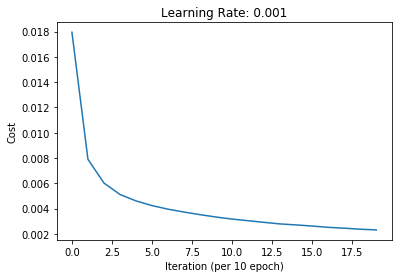

In [52]:
parameters = model(X_train, Y_train, [X_train.shape[0], 25, 25, 10], last_activation="sigmoid", optimizer="adam", epsilon=1e-8, learning_rate=0.001, epoch=20)

In [53]:
print("Training Set ", end="")
p = predict(X_train, Y_train, parameters)

Training Set Accuracy: 0.9827166666666667


In [54]:
print("Test Set ", end="")
preds = predict(X_test, Y_test, parameters)

Test Set Accuracy: 0.9637


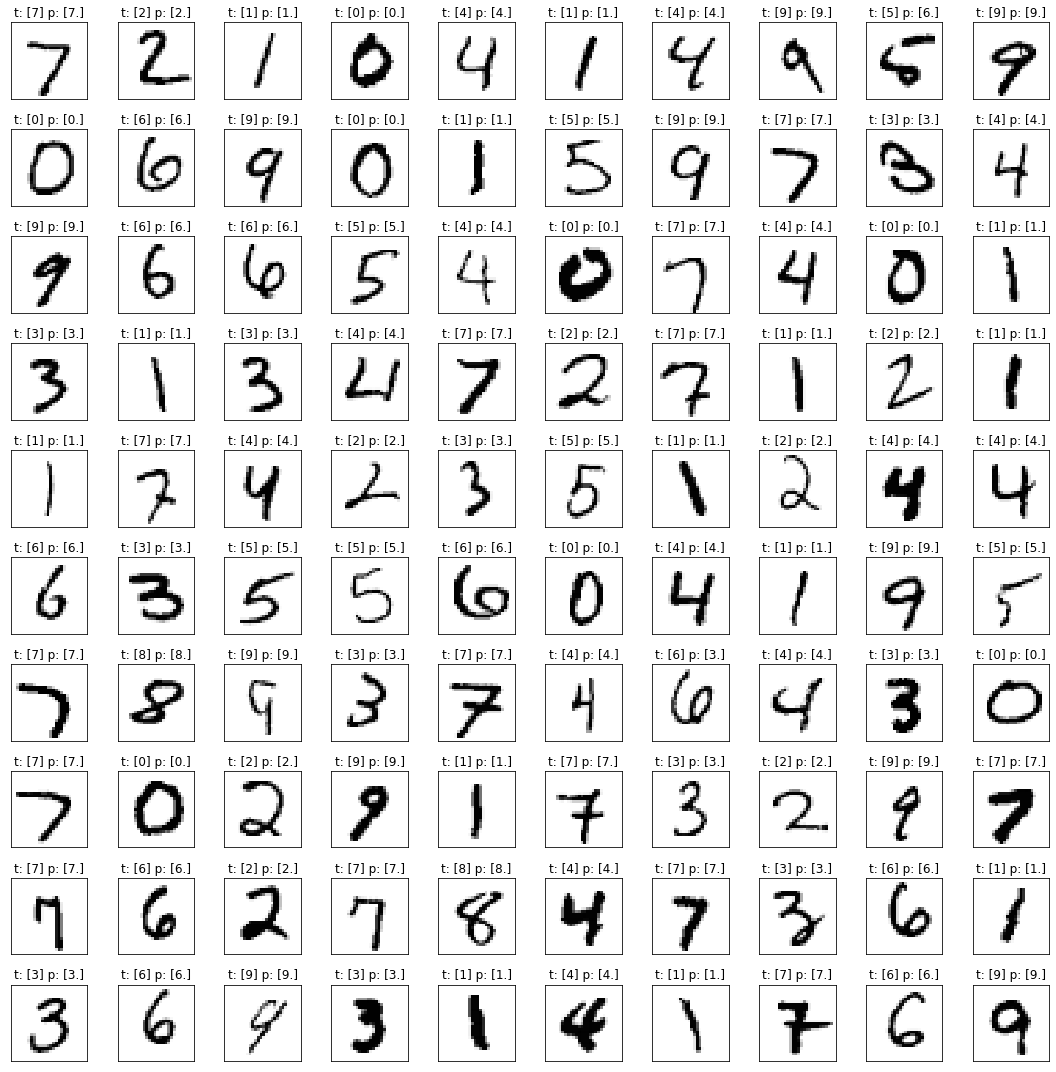

In [55]:
labeled_images(X_test, Y_test, preds, missed=False)